# Mean-shift mode seeking

In [2]:
import numpy as np
import cv2
from ex2_utils import generate_responses_1, extract_histogram, backproject_histogram, create_epanechnik_kernel, get_patch, Tracker
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

In [3]:
# Mean shift algorithm
def mean_shift(pdf, x_start, y_start, kernel_size,termination_criterium = "step_less_than_1", n_iter = 100 ,return_all_x_y = False, seed = 42):
    """Calculates the mean shift algorithm on the provided distribution"""
    # set the seed for replicability
    np.random.seed(seed)
    # Kernel has to be odd
    if kernel_size % 2 == 0:
        kernel_size += 1
    # Try the Epanechnikov kernel first (basically just multiply)
    x = x_start
    y = y_start
    # Save all points for visualization
    all_x = []
    all_y = []
    # Epsilon to not divide by 0
    eps = 1e-5
    kernel_half = kernel_size // 2
    # Pad the pdf and update the x,y
    pdf_len = pdf.shape[0] # Save the length for later
    pdf = np.pad(pdf, pad_width=kernel_size)
    x += kernel_size
    y += kernel_size

    # Get the matrices of differences
    x_diff_mtx = np.arange(-kernel_half, kernel_half+1)
    x_diff_mtx = np.tile(x_diff_mtx, (kernel_size, 1))
    y_diff_mtx = x_diff_mtx.T


    for i in np.arange(n_iter):
        # Get the weights matrix
        weights_mtx = pdf[y-kernel_half:y+kernel_half+1,x-kernel_half:x+kernel_half+1]
        # If the sum of weigths is currently zero randomly pick another position
        if np.sum(weights_mtx) < eps:
            return x,y
            # x = round(np.random.random() *pdf_len) 
            # y = round(np.random.random() * pdf_len) 

            # continue
        # Change them so that it will be a pdf on the current patch (sum of weights to 1)
        weights_mtx = weights_mtx / (np.sum(weights_mtx))

        # Get the positions matrices for x and y
        x_i_mtx = (x * np.ones_like(x_diff_mtx) + x_diff_mtx)
        y_i_mtx = (y * np.ones_like(x_diff_mtx) + y_diff_mtx)
        x_new = np.sum(x_i_mtx * weights_mtx) / (np.sum(weights_mtx) + eps)
        y_new = np.sum(y_i_mtx * weights_mtx) / (np.sum(weights_mtx) + eps)

        all_x.append(round(x_new) - kernel_size)
        all_y.append(round(y_new) - kernel_size)

        # Check the termination criterium
        if termination_criterium == "step_less_than_1":
            if (np.abs(x - x_new) < 0.5) and (np.abs(y - y_new) < 0.5):
                #print(i)
                x = round(x_new)
                y = round(y_new)
                break
        # larger step, can only be used for larger kernels
        if termination_criterium == "custom_length":
            if ((x-x_new)**2 + (y - y_new)**2 < 3):
                #print(i)
                x = round(x_new)
                y = round(y_new)
                break
        # Stop if the change in density isn't large (say in report that this isnt great so you will only use this to stop if it goes down)
        if termination_criterium == "density_diff" and i > 4:
            if pdf[round(y_new), round(x_new)] - pdf[y,x] < 1e-5:
                #print(i)
                x = round(x_new)
                y = round(y_new)
                break


        x = round(x_new)
        y = round(y_new)

    if return_all_x_y:
        return all_x,all_y
    return x - kernel_size,y - kernel_size

In [4]:
def plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap = True):
    # Visualize the landscape with the computed mode
    #plt.figure(figsize=(6,5))
    x_plot,y_plot = np.arange(landscape.shape[0]), np.arange(landscape.shape[1])
    x_plot,y_plot  = np.meshgrid(x_plot,y_plot)
    # ax.plot_surface(x_plot,y_plot , landscape, alpha = 0.5)
    if new_heatmap:
        sns.heatmap(landscape)
    # Visualize the steps
    plt.scatter(all_x,all_y, color = "green")

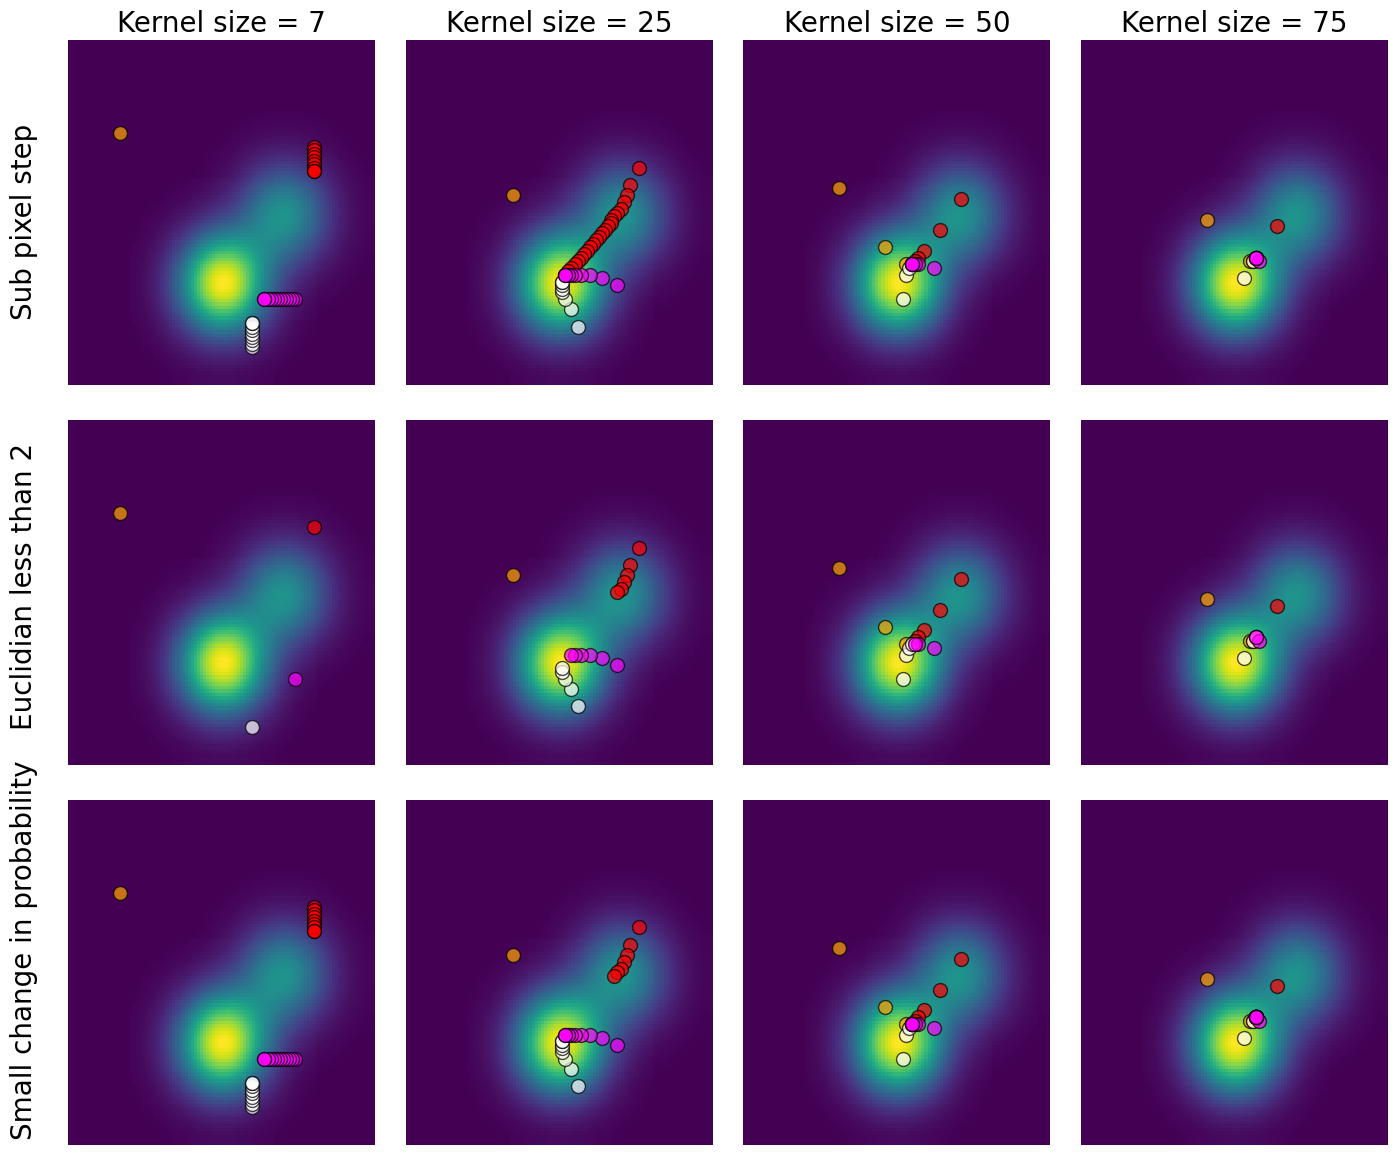

In [9]:
# Load the function landscape
landscape = generate_responses_1()
# Report: if the kernel to small, it doesnt converge
#all_x,all_y = mean_shift(landscape,40,34,25, return_all_x_y=True, termination_criterium="density_diff") 
# Visualize the landscape with the computed mode
#plot_mean_shift_convergence(landscape, all_x, all_y)
#all_x,all_y = mean_shift(landscape,40,34,25, return_all_x_y=True, termination_criterium="density_diff") 
#plot_mean_shift_convergence(landscape, all_x, all_y)

# REPORT plot, rows different termination, cols different kernel sizes
x_plot,y_plot = np.arange(landscape.shape[0]), np.arange(landscape.shape[1])
x_plot,y_plot  = np.meshgrid(x_plot,y_plot)
fix, axes = plt.subplots(3,4, figsize = (15,13))

# Add custom row titles using fig.text
row_titles = ["Sub pixel step", "Euclidian less than 2", "Small change in probability"]

for i, (row, term_crit) in enumerate(zip(axes, ["step_less_than_1", "custom_length", "density_diff"])):
      # Set the row title
    fix.text(0.05, 0.76 - i * 0.28, row_titles[i], ha='right', va='center', fontsize=20, rotation=90)
    for ax, kernel_size in zip(row, [7, 25, 50, 75]):
        # Set the title for each subplot
        if term_crit == "step_less_than_1":
            ax.set_title(f"Kernel size = {kernel_size}", fontsize=20)

        # Create the heatmap with better styling
        sns.heatmap(landscape, cmap="viridis", ax=ax, cbar=False, xticklabels=False, yticklabels=False)

        # Scatter plot with customized markers and colors
        for x_start, y_start, col in zip([10, 80, 60, 75], [20, 30, 90, 75], ["orange", "red", "white", "magenta"]):
            all_x, all_y = mean_shift(landscape, x_start, y_start, kernel_size, term_crit, return_all_x_y=True)
            ax.scatter(all_x, all_y, color=col, s=100, edgecolors='black', marker='o', alpha=0.7)


# Adjust layout to avoid overlap and ensure the labels fit
plt.subplots_adjust(left=0.07, right=0.95, top=0.9, bottom=0.05, wspace=0.1, hspace=0.1)
plt.savefig("report/figures/mode_seeking.png")


## My own functions

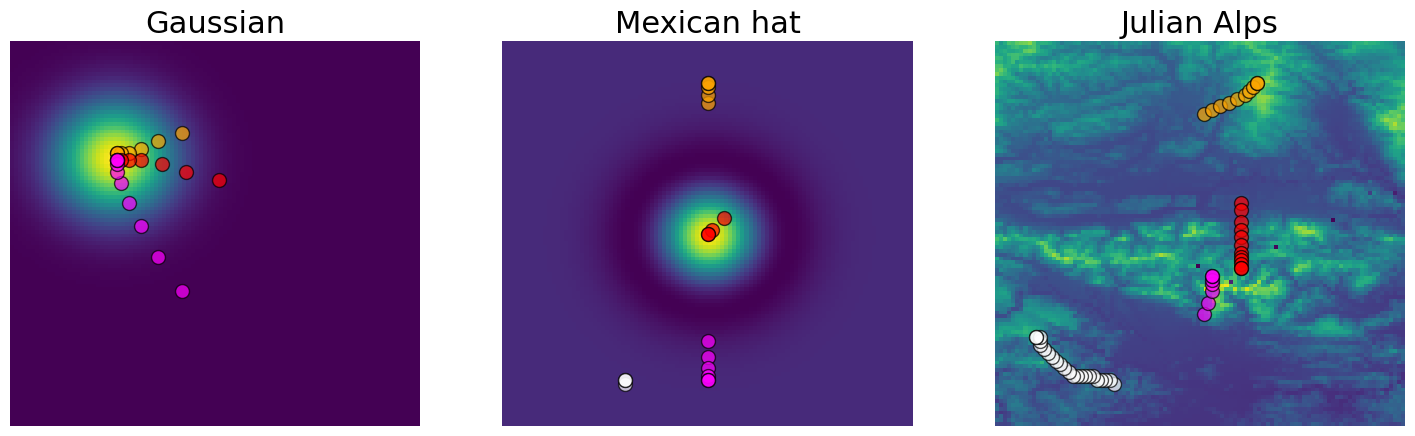

In [12]:
# Gaussian
size = 100
mew_x, mew_y = size//2 - size//4 , size//2  - size//5
sigma_x, sigma_y = 10,10
x = np.arange(size)
y = np.arange(size)
x,y = np.meshgrid(x,y)
gaussian_pmf = 1/(2 * np.pi * sigma_x * sigma_y) * np.exp(-((x - mew_x) ** 2) / (2 * sigma_x**2) - ((y - mew_y) ** 2) / (2 * sigma_y**2))

# LoG - raised mexican hat
mew_x, mew_y = size//2  , size//2 
sigma_x = 10
# Correct LoG definition using the center values
LoG_pmf = (1 / (np.pi * sigma_x**4)) * (1 - ((x - mew_x)**2 + (y - mew_y)**2) / (2 * sigma_x**2)) * \
          np.exp(-((x - mew_x)**2 + (y - mew_y)**2) / (2 * sigma_x**2))
LoG_pmf -= np.min(LoG_pmf)

# Slovenian Alps
with rasterio.open("mountain_data/L33/N46E014.hgt") as src:
    landscape = src.read(1)
landscape = np.clip(landscape,-100, 3000)
landscape = cv2.resize(landscape, (100,100))

fix, axes = plt.subplots(1,3, figsize = (18,5))
for ls,ax,title in zip([gaussian_pmf, LoG_pmf, landscape],axes, ["Gaussian", "Mexican hat", "Julian Alps"]):
    # Create the heatmap with better styling
    sns.heatmap(ls, cmap="viridis", ax=ax, cbar=False, xticklabels=False, yticklabels=False)
    ax.set_title(title, fontsize=22) 

    # Scatter plot with customized markers and colors
    for x_start, y_start, col in zip([50, 60, 30, 50], [20, 40, 90, 75], ["orange", "red", "white", "magenta"]):
        all_x, all_y = mean_shift(ls, x_start, y_start, 25, return_all_x_y=True)
        ax.scatter(all_x, all_y, color=col, s=100, edgecolors='black', marker='o', alpha=0.7)
plt.savefig("report/figures/mode_seeking2.png")


# landscape = cv2.resize(landscape, (100,100))
# all_x,all_y = mean_shift(landscape,90,90,40, return_all_x_y=True) 
# plot_mean_shift_convergence(landscape, all_x, all_y)
# all_x,all_y = mean_shift(landscape,99,1,40, return_all_x_y=True) 
# plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)
# all_x,all_y = mean_shift(landscape,30,86,40, return_all_x_y=True) 
# plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)
# all_x,all_y = mean_shift(landscape,40,30,45, return_all_x_y=True) 
# plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)


# all_x,all_y = mean_shift(gaussian_pmf,70,40,15, return_all_x_y=True) 
# plt.figure()
# plot_mean_shift_convergence(gaussian_pmf, all_x, all_y)
# # Perform mean shift
# all_x, all_y = mean_shift(LoG_pmf, 70, 30, 15, return_all_x_y=True)
# plt.figure()
# plot_mean_shift_convergence(LoG_pmf, all_x, all_y)